# LONGITUDINAL REGIMES OF THE HUMAN GUT MICROBIOME

This Jupyter Notebook contains main functions to define longitudinal regimes of the human gut microbiome


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

### Define longitudinal regimes

In [2]:
wd = './data/ready_files/'

In [3]:
df = pd.read_csv('./data/ts_charactericstics_tables/LONGITUDINAL_CHARACTERISTICS_DF.csv')

male_df = pd.read_csv(wd + 'male_rarefied_18000_interpolated_pchip.tsv', sep = '\t', index_col = [0]).T
female_df = pd.read_csv(wd + 'female_rarefied_18000_interpolated_pchip.tsv', sep = '\t', index_col = [0]).T
donorA_df = pd.read_csv(wd + 'donorA_rarefied_18000_interpolated_pchip.tsv', sep = '\t', index_col = [0]).T
donorB_df = pd.read_csv(wd + 'donorB_rarefied_18000_interpolated_pchip.tsv',sep = '\t', index_col = [0]).T

def filter_dataset(data, treshold=150):
    
    df = data.iloc[:treshold]
    df_sum = df.sum().reset_index().sort_values(by = [0])
    keep_features = df_sum[df_sum[0] != 0]['index'].values
    data_filtered = df[keep_features]
    
    return data_filtered

#donorB_df = filter_dataset(donorB_df)

datasets = [male_df, female_df, donorA_df, donorB_df]
subjects = ['male', 'female', 'donorA', 'donorB']

In [4]:
colors = [ '#8d99ae', '#0f4c5c', '#fcca46', '#a1c181', '#e36414', '#457b9d']
regimes = ['noise', 'rare', 'stable_temporal', 'unstable_temporal', 'unstable_prevalent', 'stable_prevalent']

In [5]:
def conditions(s):
    if (s['prevalence'] < .1) and (s['white_noise_binary'] == 1):
        return 'noise'
    elif (s['prevalence'] < .1) and (s['white_noise_binary'] == 0):
        return 'rare'
    elif (s['prevalence'] > .9) and (s['stationary'] == 1) and (s['white_noise_binary'] == 0):
        return 'stable_prevalent'
    elif (s['prevalence'] > .9) and (s['stationary'] == 0) and (s['white_noise_binary'] == 0):
        return 'unstable_prevalent'
    elif (s['prevalence'] < .9) and (s['prevalence'] > .1) and (s['stationary'] == 1) and (s['white_noise_binary'] == 0):
        return 'stable_temporal'
    elif (s['prevalence'] < .9) and (s['prevalence'] > .1) and (s['stationary'] == 0) and (s['white_noise_binary'] == 0):
        return 'unstable_temporal'

df['regime'] = df.apply(conditions, axis=1)

### Plot quantity of each regime

In [6]:
from collections import Counter
REGIME_DF = pd.DataFrame()
for i in range(0, 4):
    
    d=Counter(df[(df['subject'] == subjects[i])].regime)
    res_df = pd.DataFrame.from_dict(d, orient='index').reset_index()
    res_df.columns = ['seasonal', 'count']
    res_df = res_df.set_index('seasonal').T
    res_df['subject'] = subjects[i]
    REGIME_DF = pd.concat([REGIME_DF, res_df])
    
REGIME_DF = REGIME_DF[['noise', 'rare', 'stable_temporal', 'unstable_temporal', 'unstable_prevalent', 'stable_prevalent', 'subject']]

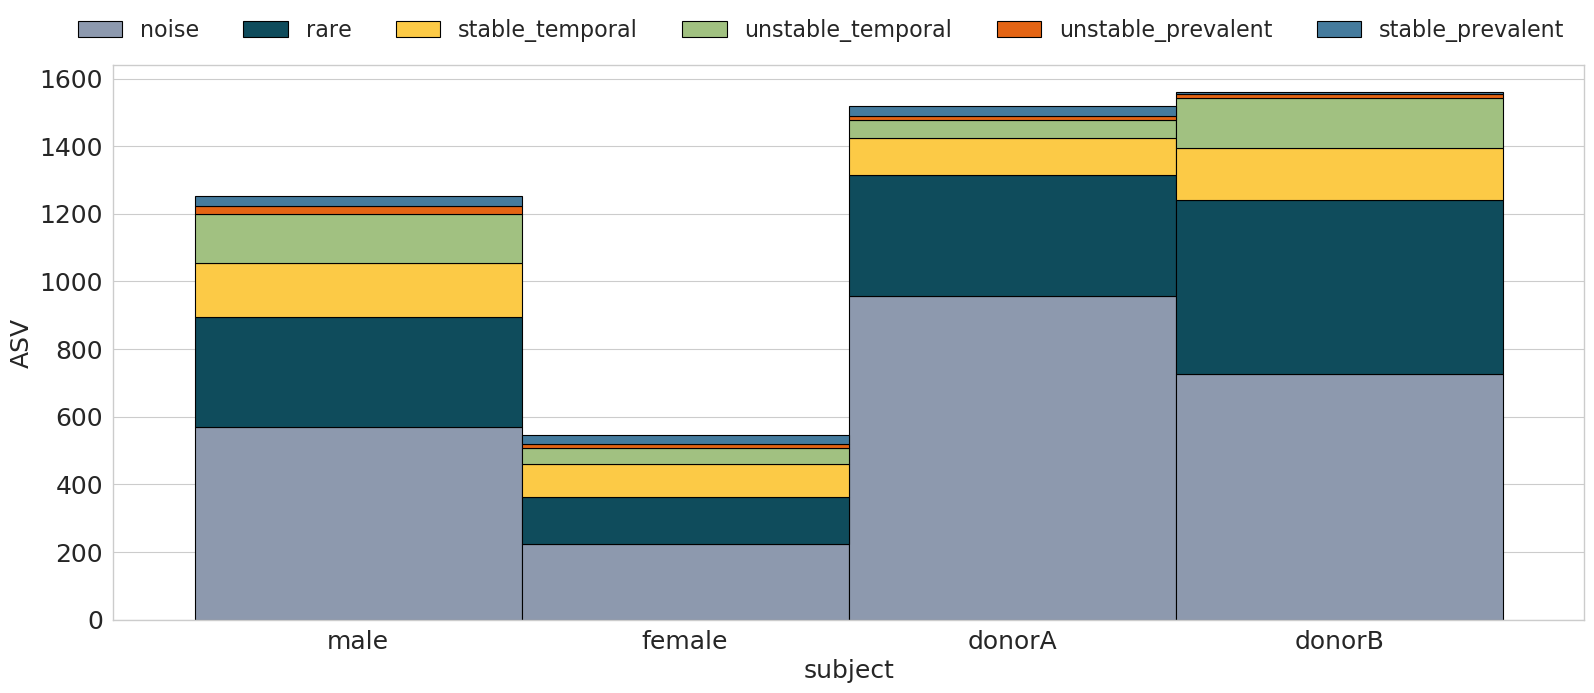

In [75]:
ax = REGIME_DF.iloc[:, :7].plot(kind='bar', stacked=True, figsize = (17, 7), width=1, edgecolor='k',lw=.8,
                           color = colors)#['#cccccc', '#999999', '#81b29a', '#5f797b', '#fb8500', '#219ebc'])
plt.legend(loc ='upper right', bbox_to_anchor=(1, 1.12), edgecolor='white', fontsize=16, ncol=6)
ax.set_xticklabels(['male', 'female', 'donorA', 'donorB'], rotation=0, fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.set_xlabel('subject', fontsize=18)
ax.set_ylabel('ASV', fontsize=18)
ax.grid(axis='x')
plt.tight_layout()

### Plot regimes flucturation in time

In [68]:
def plot_regimes(df, ftable, subject, legend=False):
    
    df = df
    ftable = ftable.reset_index().rename({'index':'feature'}, axis=1)

    merged_df = pd.merge(ftable, df[['feature', 'regime']], on = 'feature')
    merged_df = merged_df.drop('feature', axis=1).groupby(by = 'regime').sum()
    merged_df_t = merged_df.T
    rel_ab_df = merged_df_t.div(merged_df_t.sum(axis=1), axis=0)
    rel_ab_df = rel_ab_df[regimes]
    
    colors = [ '#8d99ae', '#0f4c5c', '#fcca46', '#a1c181', '#e36414', '#457b9d']
    
    rel_ab_df_rolling = rel_ab_df.transform(lambda x: x.rolling(window=3).mean()).dropna().reset_index(drop=True)


    ax = rel_ab_df_rolling.plot(kind='bar', stacked=True, width=1, edgecolor='k', lw=0, figsize = (20, 3), color=colors)
    
    if legend == True:
        
        plt.legend(bbox_to_anchor=(1, 1.3),loc = 'upper right', title= 'REGIME', ncol=6, edgecolor='k', fontsize=14)
        plt.rcParams['legend.title_fontsize'] = 'xx-large'
    
    elif legend == False:   
        ax.get_legend().remove()

    plt.xticks(np.arange(0, ftable.shape[1], 100), [0, 100, 200, 300])
    plt.tick_params(axis='both', which='major', labelsize=18, labelrotation = 0)
    plt.tick_params(axis='both', which='minor', labelsize=18, labelrotation = 90)
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.show()

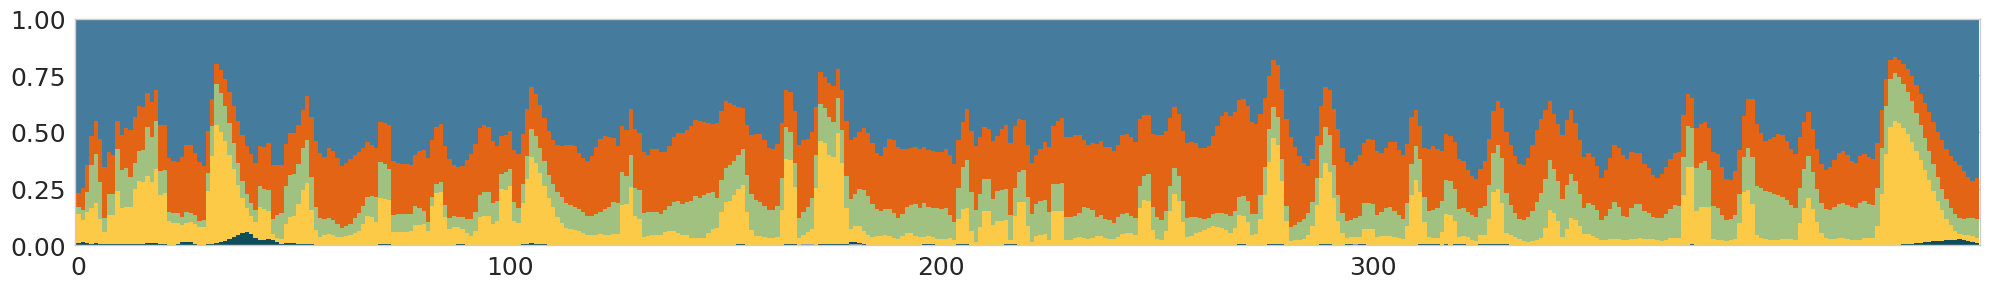

In [64]:
plot_regimes(df[df['subject'] == 'male'], male_df.T, 'male', False)

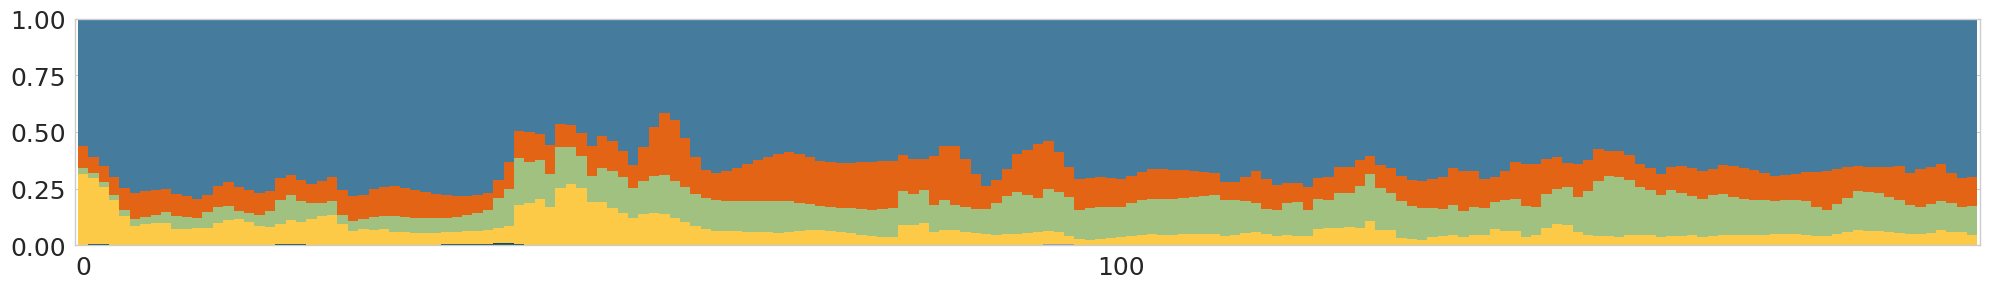

In [65]:
plot_regimes(df[df['subject'] == 'female'], female_df.T, 'female', False)

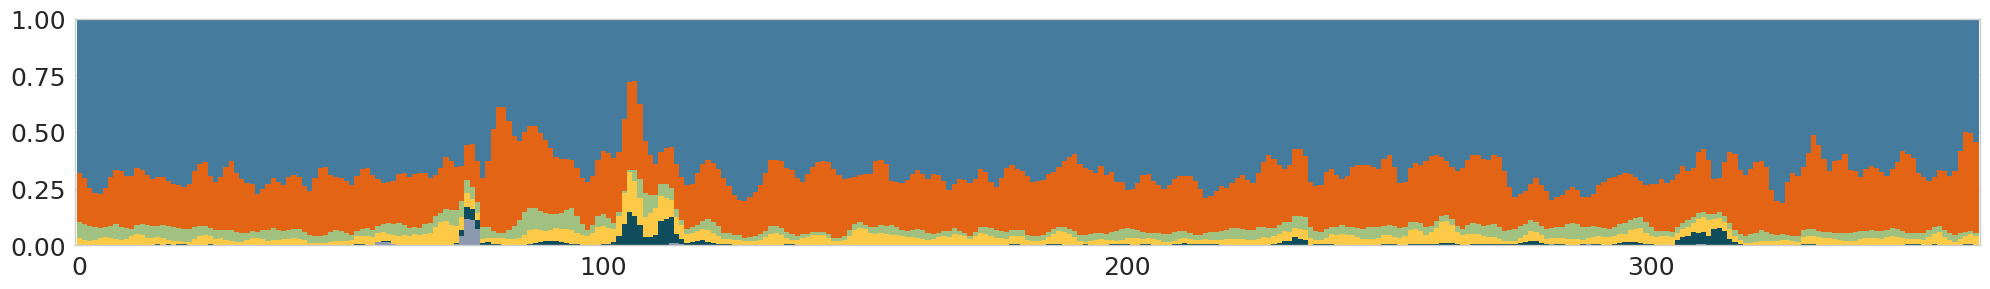

In [66]:
plot_regimes(df[df['subject'] == 'donorA'], donorA_df.T, 'donorA', False)

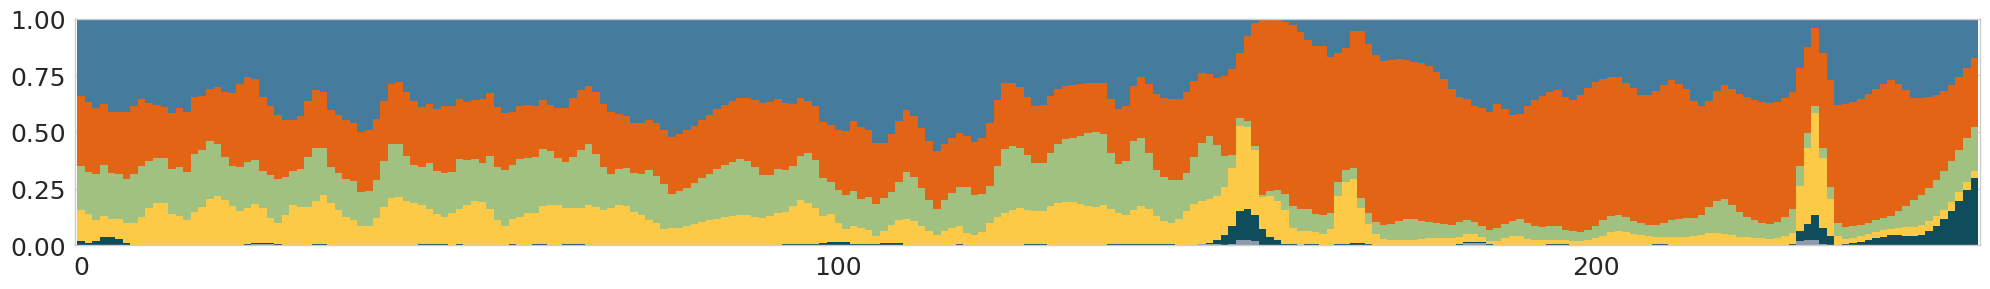

In [67]:
plot_regimes(df[df['subject'] == 'donorB'], donorB_df.T, 'donorB', False)

### Loading of longitudinal regimes 

Text(0, 0.5, 'Loading')

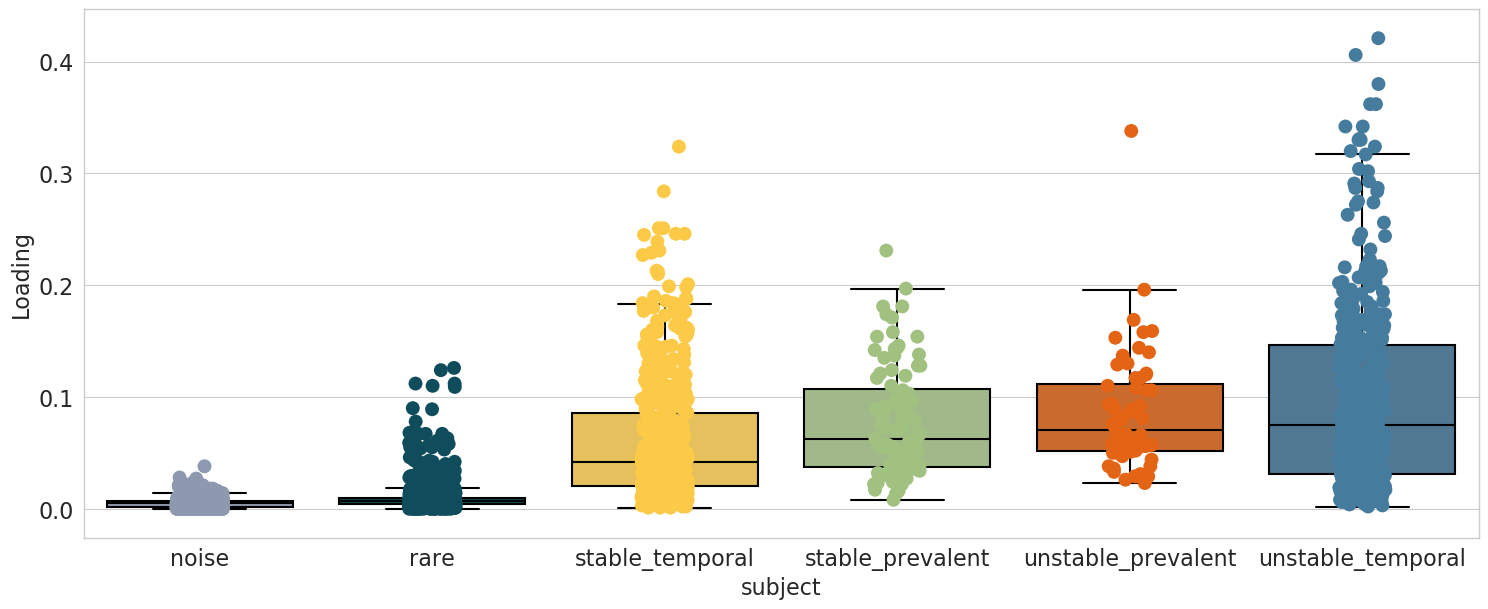

In [42]:
df['loading'] = df['PC1_loading'] + df['PC2_loading']

sns.set_style('whitegrid')
plt.figure(figsize = (18, 7))
colors = [ '#8d99ae', '#0f4c5c', '#fcca46', '#a1c181', '#e36414', '#457b9d']
c = 'k'
sns.boxplot(data=df, x = 'regime', y = 'loading', palette = colors,fliersize=0, 
            boxprops=dict(edgecolor= 'k'),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            medianprops=dict(color=c))

sns.stripplot(data=df, x = 'regime', y = 'loading', palette = colors, s=10)
#plt.grid('x')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xlabel('subject', fontsize=16)
plt.ylabel('Loading', fontsize=16)